In [2]:
import pandas as pd
import numpy as np
import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_selection import chi2 # хи-квадрат

# для анализа характера отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lyudmila\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Для рандомфореста не очень нужны нормализация, а для deep learning - очень нужно

In [3]:
hotels = pd.read_csv('data\hotels.csv')
display(hotels)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066


In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
print(hotels.nunique())

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1472
lng                                             1472
dtype: int64


### Преобразование данных

In [6]:
# Залогируем проект, чтобы отслеживать изменение метрики

from comet_ml import Experiment
experiment = Experiment(
    api_key='yvb5FJsAoasdABszflop35Pbk',
    project_name='Project-3',
    workspace='lyudmilat',
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/lyudmilat/project-3/fbfe8d7acd20418ab77ec3c54cde9227



Получение первого значения\
Первая версия преобразования: удаление текстовых столбцов, заполнение средней пропущенных значений

In [7]:
hotels_initial = hotels.copy() # сделаем копию начального датасета
hotels = hotels.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review'], axis = 1)
# другой вариант
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

values = {
    'lat': hotels['lat'].mean(),
    'lng': hotels['lng'].mean()}
hotels = hotels.fillna(values)

MAPE: 0.14132330514943972

Ответим на тестовые вопросы из юнита

In [8]:
# отвечаем на вопросы в юните
# Когда был оставлен самый первый/свежий отзыв?

hotels_for_questions = hotels_initial #возвращаем исходный датасет

hotels_for_questions['review_date'] = pd.to_datetime(hotels_for_questions['review_date'], format='%m/%d/%Y')
hotels_for_questions['review_date'].min()
hotels_for_questions['review_date'].max()

# Сколько уникальных тэгов, какие наиболее популярные
tag_sum = []
tags_all = []
tag_count = 0
for i in hotels_for_questions['tags']:
    tags_string = i.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip().replace("[", '').replace("]", ''), tags_list))
    for tag in tags_list:
        tags_all.append(tag)
        if tag in tag_sum :
            pass
        else: 
            tag_sum.append(tag)
            tag_count += 1

# Наиболее популярный тэг
c2 = Counter()
c = Counter(tags_all)
#print(c, tag_count)

Вторая версия с детальной проработкой данных

## Что сделаем со строковыми признаками:
1. Локация:
    1. hotel_address - в оценке отеля имеет вес так называемая удаленность от центра, и отели в столичных городах и нет - оцениваются по разному. Попробуем вытащить из этого признака город и страну
    2. У нас есть признаки долготы и широты, попробуем выгрузить точки центров столиц долготы и широты отсюда (https://www.fittotravel.net/index.php/international-data/257-coordinates-of-world-capitals) и посчитать удаленность от центра
    3. У нас есть страна человека оставившего отзыв, введем бинарный признак совпадает она со страной отеля или нет. Вероятность накрутки может быть выше, если человек местный
2. Дата отзыва: выделим день недели и признак выходной день или нет
3. Тексты отзывов: проанализируем отзывы на настроение
4. Сделаем перекрестные признаки по количеству отзывов, негативные/позитивные, с самим ревьювером
5. Из тэгов выделим несколько бинарных признаков

### 1. Локация
Начнем со всех преобразований адреса

Страна в названии последняя (за исключением Великобритании), а город предпоследний (в Великобритании 5 с конца)

In [44]:
hotels = hotels_initial #возвращаем исходный датасет

# выделяем страну
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])

# переименовываем Kingdom в United Kingdom
hotels.loc[hotels['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'
# смотрим что получилось
hotels['hotel_country'].value_counts()

# выделяем город
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
# смотрим что получилось
hotels['hotel_city'].value_counts()

hotel_city
London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: count, dtype: int64

In [45]:
# Добываем данные о координатах стран и столиц
import requests # Импортируем библиотеку requests
from bs4 import BeautifulSoup
import re

url = 'https://www.fittotravel.net/index.php/international-data/257-coordinates-of-world-capitals' 
table1 = pd.read_html(url)[0]

country_locations = pd.DataFrame(table1)

# переименуем несовпадения
country_locations.loc[country_locations['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'United Kingdom'
country_locations.loc[country_locations['Country'] == 'Palau', 'Latitude'] = '7.5004N'

# видим, что в нашем датасете у Испании нет столицы, есть только Барселона. Предполагая, что нет смысла анализировать расстояние до Мадрида, заменим данные Испании на Барселону
country_locations.loc[country_locations['Country'] == 'Spain', ['Capital','Latitude', 'Longitude']] = ['Barcelona', '41.39N', '2.154E']

# Преобразуем формат геоданных
def change_type_geo(arg):
    if 'N' in arg or 'E' in arg:
        pre_result = re.findall('[0-9\.]', arg) # находит цифры и точки, преобразуем в число из строки
        result = float(''.join(pre_result))
    else:
        pre_result = re.findall('[0-9\.]', arg)
        result = - float(''.join(pre_result))
    return result

country_locations['Latitude'] = country_locations['Latitude'].apply(change_type_geo)
country_locations['Longitude'] = country_locations['Longitude'].apply(change_type_geo)
display(country_locations)

,Capital,Country,Latitude,Longitude
0,Kabul,Afghanistan,34.28,69.11
1,Tirana,Albania,41.18,19.49
2,Algiers,Algeria,36.42,3.08
3,Pago Pago,American Samoa,-14.16,-170.43
4,Andorra la Vella,Andorra,42.31,1.32
...,...,...,...,...
194,Caracas,Venezuela,10.30,-66.55
195,Hanoi,Viet Nam,21.05,105.55
196,Belgrade,Yugoslavia,44.50,20.37
197,Lusaka,Zambia,-15.28,28.16


In [46]:
# Добавим в наш основной датасет данные о центре городов
hotels = hotels.merge(
    country_locations,
    left_on='hotel_country',
    right_on='Country',
    how='left'
)
# дропнем дубляжи
hotels = hotels.drop(['Country', 'Capital'], axis = 1)
# переименуем новые столбцы
hotels.rename(columns = {'Latitude': 'latitude_center', 'Longitude' : 'longitude_center'}, inplace = True)

# больше нет смысла в названии, удаляем его
hotels = hotels.drop(['hotel_address'], axis = 1)

display(hotels.head(3))

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,hotel_country,hotel_city,latitude_center,longitude_center
0,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,London,51.36,-0.05
1,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,London,51.36,-0.05
2,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,France,Paris,48.50,2.20


In [47]:
# Добавим признак, совпадает ли страна ревьювера со страной отеля
hotels['equal_countries'] = (hotels['reviewer_nationality'] == hotels['hotel_country'])

Занимаемся геометками, делаем признак о расстоянии отеля от центра города

In [48]:
# работа с геометками
# В данных 'lat' и 'lng' есть пропуски, поэтому разделим на группы по городам и заполним медианой

# пропуски в lng и lat в одних местах, поэтому группировки по одной метрике достаточно
print(hotels[hotels['lng'].isnull()].groupby('hotel_city', as_index=False).agg(quantity=('hotel_city', 'count'))) # добавляем аргумент количества

# формируем объект SeriesGroupBy
city_hotels = hotels.groupby(['hotel_city'], group_keys=False)

# заменяем пропуски соответствующим медианным значением
hotels['lat'] = city_hotels['lat'].apply(lambda x: x.fillna(x.median()))
hotels['lng'] = city_hotels['lng'].apply(lambda x: x.fillna(x.median()))

hotels.info()

  hotel_city  quantity
0  Barcelona       159
1      Paris       299
2     Vienna      1990
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386803 non-null  int64         
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   hotel_name                                  386803 non-null  object        
 4   reviewer_nationality                        386803 non-null  object        
 5   negative_review                             386803 non-null  object        
 6   review_total_negative_word_counts           386803 non-null  int64         
 7   total_number_of_reviews                     386803 non-null  in

In [49]:
# работа с геометками
from geopy.distance import geodesic as GD

def make_distance(row):
    """
    transforming lat and lng to distance 

    Args:
        arg (_row_): row from DataFrame

    Returns:
        float: distance from the point to capital centre
    """
    result = GD((row['lat'], row['lng']), (row['latitude_center'], row['longitude_center'])).km
    return result

# делаем столбец с расстоянием до центра
hotels['Distance_to_cap_centre'] = hotels.apply(make_distance, axis=1)
display(hotels.head(3))

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,tags,days_since_review,lat,lng,hotel_country,hotel_city,latitude_center,longitude_center,equal_countries,Distance_to_cap_centre
0,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,London,51.36,-0.05,False,17.696678
1,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,London,51.36,-0.05,False,18.620333
2,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,France,Paris,48.50,2.20,False,39.506151


In [51]:
# уменьшим разброс, сделаем признак дискретным с градацией
hotels['Distance_to_cap_centre'].min() # 0.21789697004820627
hotels['Distance_to_cap_centre'].max() # 510.61405972592945

def distance_discrete(arg):
    if 0 < arg <= 5:
        result = 1
    elif 5 < arg <= 10:
        result = 2
    elif 10 < arg <= 20:
        result = 3
    elif 20 < arg <= 30:
        result = 4
    elif 30 < arg <= 40:
        result = 5
    elif 40 < arg <= 50:
        result = 6
    elif 50 < arg <= 200:
        result = 7
    else: result = 8
    return result

hotels['Distance_to_cap_centre'] = hotels['Distance_to_cap_centre'].apply(distance_discrete)

### 2. Преобразования даты

In [52]:
# Преобразуем дату отзыва в формат даты
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

# Выделим признаки дня недели и выходного дня
hotels['weekday'] = hotels['review_date'].apply(lambda x: x.date().weekday())
hotels['is_weekend'] = hotels['weekday'].apply(lambda x: 1 if x in (5, 6) else 0)

# Извлечем год, месяц, день
hotels['year'] = hotels['review_date'].dt.year
hotels['month'] = hotels['review_date'].dt.month
hotels['day'] = hotels['review_date'].dt.day

# Удалим исходный столбец
hotels = hotels.drop('review_date', axis=1) 

In [53]:
# Приведем столбец days_since_review в int
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: re.search(r'\d+', x)[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int')

### 3. Тексты отзывов

## МОЖНО улучшить

Существует такое понятие, как векторизация слов. Каждое слово может быть представлено отдельным числом. Для этого можно использовать библиотеку gensim. Использование Doc2Vec. Об этом более подробно в итоговом вебинаре.

Запись итогового вебинара:
https://us02web.zoom.us/rec/share/qoBLJFQpQHhkoaFS77dl0EkWRRvy226xr1pHO7b7Cz6cwJN8Y148vaJQ-DDCEEz6.aFGotJSRNbS59tUP?startTime=1663866000000
Код доступа: +5s72pfL

In [54]:
# Анализируем характер отзыва - больше негативный или больше позитивный
sent_analyzer = SentimentIntensityAnalyzer()

# чтобы не сбивать алгоритм, заменим No Positive\No negative по принципу если нет позитивной части, то все плохо, если нет негативной, то всё хорошо
hotels.loc[hotels['negative_review'] == 'No Negative', 'negative_review'] = 'Good'
hotels.loc[hotels['positive_review'] == 'No Positive', 'positive_review'] = 'Bad'

hotels['rw_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['rw_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 
# display(hotels)

# можно выделить все метрики, а можно взять именно Compound - он агрегированный и нормализованный. также можно совместить позитивный и негативный отзыв, получить совокупный compound   
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels['sum_compound'] = (hotels['n_compound'].astype(float)+hotels['p_compound'].astype(float))/2

### 4. Перекрестные признаки с отзывами

In [55]:
# Соотношение того, сколько позитивного написали в отзыве к негативной части
hotels['positive_word_part'] = hotels['review_total_positive_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts'])
hotels['negative_word_part'] = hotels['review_total_negative_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts'])

hotels['positive_word_part'].fillna(0,inplace=True)
hotels['negative_word_part'].fillna(0,inplace=True)

display(hotels.head())

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,sum_compound,positive_word_part,negative_word_part
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,1.000,0.0,0.0000,0.0,0.345,0.655,0.5859,0.29295,0.571429,0.428571
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,0.244,0.0,-0.4767,0.0,1.000,0.000,0.0000,-0.23835,0.400000,0.600000
2,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,Bad,0,14,...,0.577,0.0,-0.2960,1.0,0.000,0.000,-0.5423,-0.41915,0.000000,1.000000
3,34,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,Good,0,607,Friendly staff quiet comfortable room spotles...,11,8,...,0.000,1.0,0.4404,0.0,0.279,0.721,0.9169,0.67865,1.000000,0.000000
4,914,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,...,0.333,0.0,-0.2500,0.0,0.618,0.382,0.8503,0.30015,0.833333,0.166667


### 5. Тэги

In [56]:
# подсмотрела разбивку тегов и полную общность в kaggle 'Project-3 [SF-DST] Booking reviews'

# выведем число тегов для каждого отеля в отдельный признак
hotels['tags_count'] = hotels['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))

# посмотрим сколько тегов бывает по количеству, ищем максимум 
hotels['tags_count'].unique()

# смотрим структуру признака 'tag'
print(hotels[hotels['tags_count'] == hotels['tags_count'].max()]['tags'].iloc[0])
print(hotels[hotels['tags_count'] == hotels['tags_count'].max()]['tags'].iloc[3])

[' With a pet ', ' Leisure trip ', ' Solo traveler ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Business trip ', ' Couple ', ' King Room with City View Top floors ', ' Stayed 2 nights ', ' Submitted from a mobile device ']


In [57]:
# подсмотрела разбивку тегов и полную общность в kaggle 'Project-3 [SF-DST] Booking reviews'

def get_tags(tags_string):
    """ Функция кодирования отдельных тегов в новый признак

    Args:
        tags_string (str): строкое значение признака 'tags', передаваемое в обработку

    Returns:
        int: возвращает коды будущих признаков
    """

    # убираем лишнюю информацию (т.е. "мусор")
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    
    # "нарезаем" оставшуюся строку тегов во временный список
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list)) # .strip() - помогает разработчику удалить пробелы или определенные символы из строки в начале и в конце строки

    # "кодируем" путешественника(-ов)
    reviewer_types = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    # "кодируем" тип комнаты
    # словарь "выносится" наружу только ради графиков (для формирования меток по оси абсцисс)
    global room_types
    room_types = {
            'Other': 0,
            'Premier': 1, 'Royal': 2, 'President': 3, 'Presidential': 4, 'Ordinary': 5, 
            'Adjacent': 6, 'Exception': 7, 'Luxury': 8, 'Panoramic': 9, 'Classic': 10, 
            'Loft': 11, 'Montcalm': 12, 'Privilege': 13, 'Special': 14, 'Camper': 15, 
            'Sensation': 16, 'Classique': 17, 'Privilege': 18, 'Wonderful': 19, 'Deluxe': 20,
            'Premium': 21, 'Quadruple': 22, 'Triple': 23, 'Duplex': 24, 'Penthouse': 25, 
            'Townhouse': 26, 'Connecting': 27, 'Apartment': 28, 'Apartments': 29, 'Queen': 30, 
            'King': 31, 'Comfort': 32, 'Large': 33, 'Cosy': 34, 'Cozy': 35, 
            'Extra': 36, 'Plus': 37, 'Club': 38, 'Art': 39, 'View': 40,
            'Studio': 41, 'City': 42, 'Emotion': 43, 'Suite': 44, 'Executive': 45,
            'Superior': 46, 'Guest': 47, 'Family': 48, 'Business': 49,
    }

    # задаем начальные значения новых признаков
    tag_from_mobile = 0
    tag_with_pet = 0
    
    # по умолчанию не считаем поездку командировкой, значение по умолчанию 1
    tag_leisure_trip = 1

    # по умолчанию считаем поездку, что путешественник передвигается один и без детей
    tag_reviewer_type = 1
    
    # если отзыв оставлен и отсутствуют ключевые слова 'Stayed _ night(s)',
    # будем считать, что проведена минимально 1 ночь, значение по умолчанию 1
    tag_count_nights = 1
    
    # номер по умолчанию без видовых преимуществ
    tag_view_room = 0

    # если комната в тегах отсутствует, значение по умолчанию 0
    tag_room_type = 0

    # кодируем значения обнаруженных признаков при их наличии во временном списке
    for _tag in list(tags_list):
        # признак - "отправлено с мобильного устройства"
        if _tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(_tag)

        # признак - путешествие с домашними питомцами
        if _tag == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(_tag)

        # признак - поездка рабочая (командировка)
        if _tag == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(_tag)

        # признак - поездка не связана с работой (отпуск)
        if _tag == 'Leisure trip':
            # просто убираем тег из временного списка, т.к. значение по умолчанию 1
            # tag_leisure_trip = 1
            tags_list.remove(_tag)

        # признак - состав путешествующих
        if _tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[_tag]
            tags_list.remove(_tag)

        # признак - количество ночей
        if re.fullmatch(r'Stayed\s\d+\snight\w?', _tag):
            tag_count_nights = [int(n) for n in re.findall(r'-?\d+\.?\d*', _tag)][0]
            tags_list.remove(_tag)

        # признак - имеется тег "номер с видом на..."
        if len(tags_list) > 0:
            if ('View' in tags_list[0]) | ('Panoramic' in tags_list[0]):
                tag_view_room = 1

            # кодируем тип номера
            for r_t in room_types.keys():
                if r_t in tags_list[0]:
                    tag_room_type = room_types[r_t]

            # исключения, т.к. тег идет как 'Double or Twin Room 1 2 Adults'
            if ('Double' in tags_list[0]) | ('Twin' in tags_list[0]):
                tag_room_type = 50

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_view_room, tag_room_type

# создаем новые признаки
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_view_room', 'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index).astype('int8')

In [58]:
# проверяем, какие столбцы остались, что еще надо преобразовывать
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   hotel_name                                  386803 non-null  object 
 3   reviewer_nationality                        386803 non-null  object 
 4   negative_review                             386803 non-null  object 
 5   review_total_negative_word_counts           386803 non-null  int64  
 6   total_number_of_reviews                     386803 non-null  int64  
 7   positive_review                             386803 non-null  object 
 8   review_total_positive_word_counts           386803 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 

### Кодируем оставшиеся признаки, удаляем лишнее

In [59]:
hotels = pd.get_dummies(hotels, columns=['hotel_country', 'hotel_city'])

hotels = hotels.drop(['hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 'latitude_center',
    'longitude_center', 'rw_neg', 'rw_pos'], axis = 1)

In [60]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   equal_countries                             386803 non-null  bool   
 9   Distance_to_cap_centre                      386803 non-null  int64  
 

Отбор признаков.

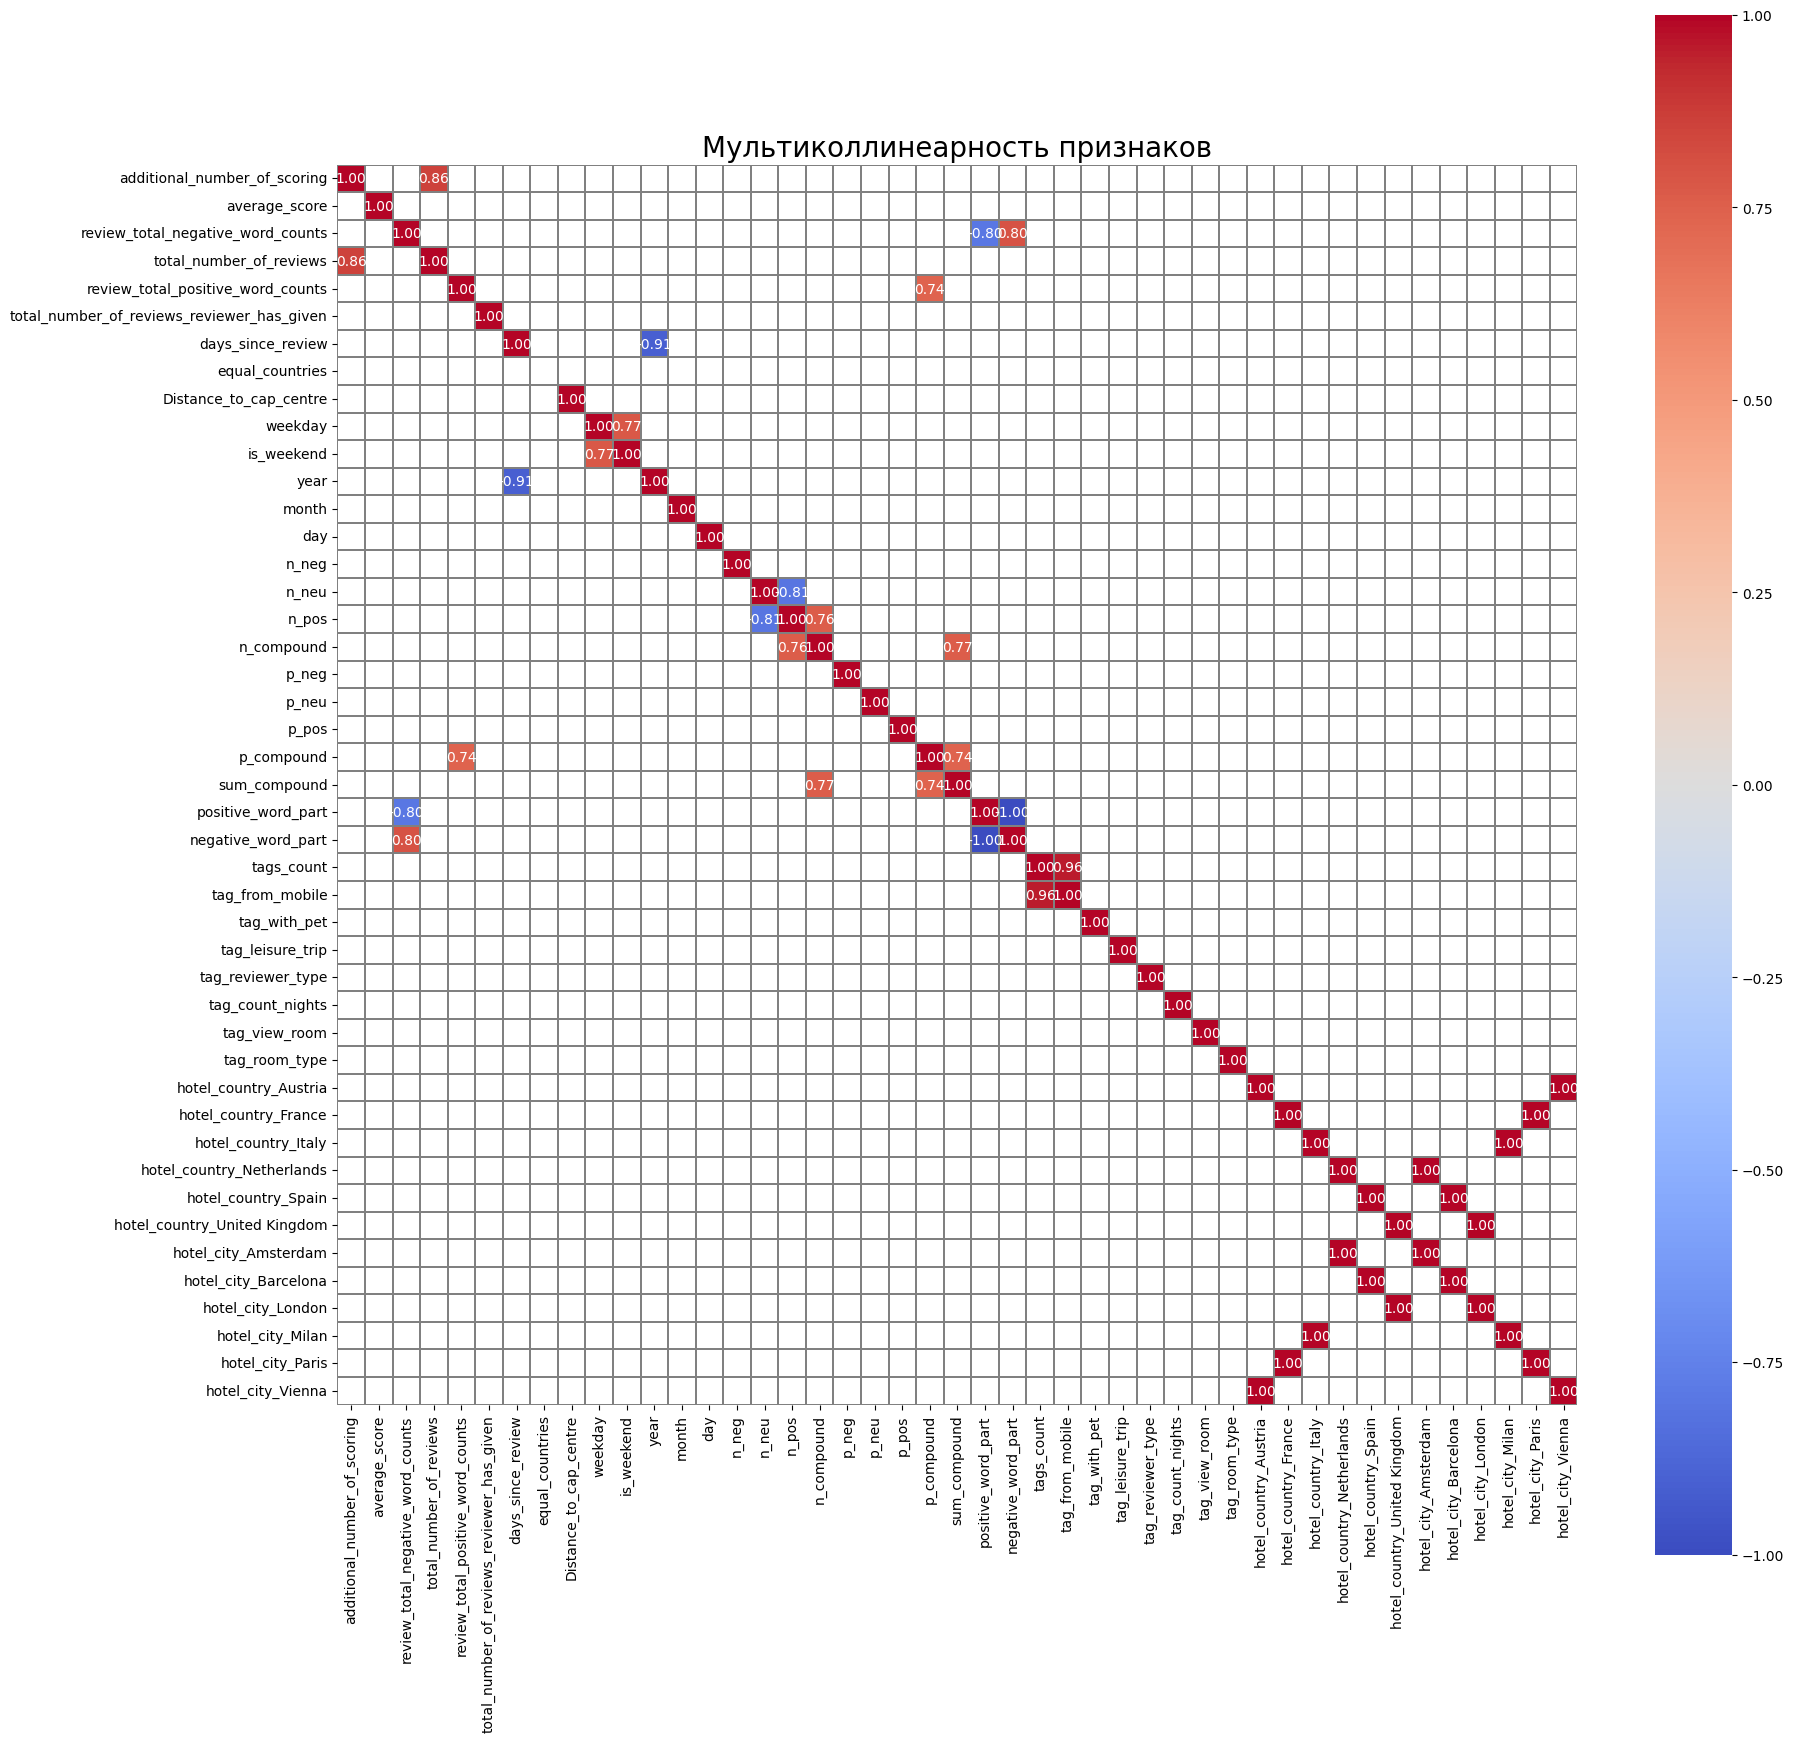

In [61]:
# Анализ мультиколлинеарности

# данные для построения графика
corr = hotels.drop(['reviewer_score'], axis=1).corr(method='spearman')
plt.subplots(figsize=(20, 20))

# график - тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

Рассмотрим в разрезе оценки ANOVA и Хи-квадрат\
Оценка значимости признаков

Для оценки значимости признаков будем использовать тесты:

- хи-квадрат - для категориальных,\
- тест ANOVA - для числовых (непрерывных) признаков.

### Разделение данных на 2 выборки

In [62]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

### Оценка значимости каждого признака для целевой переменной

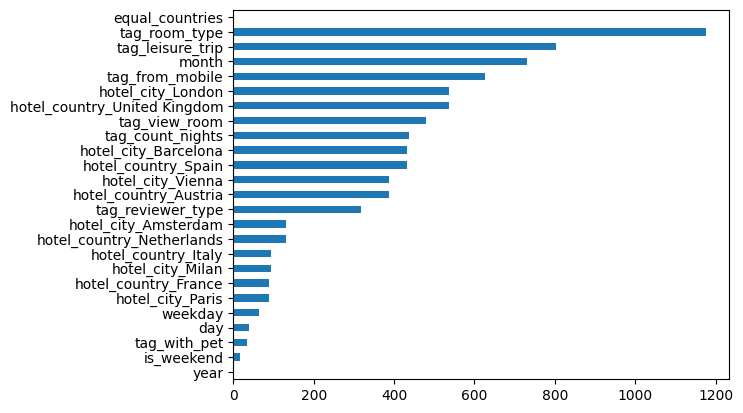

In [63]:
# При помощи теста мы сможем узнать, как географическая долгота отеля и количество негативных отзывов влияют на его рейтинг
# Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

num_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews', 'tags_count',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given', 'days_since_review', 'Distance_to_cap_centre',
             'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound', 'positive_word_part', 'negative_word_part','sum_compound']

# категориальные признаки
cat_cols = ['is_weekend', 'year', 'month', 'day', 'tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 'tag_reviewer_type', 'tag_count_nights', 
            'tag_view_room', 'tag_room_type', 'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain',
            'hotel_country_United Kingdom', 'hotel_city_Amsterdam', 'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan', 'hotel_city_Paris', 
            'hotel_city_Vienna', 'weekday','equal_countries']

y=y.astype('int')


imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols) #  Метод chi2 возвращает массив значений хи-квадрат и p-value для каждого признака
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# сделать график, залогировать график

experiment.log_figure(figure=plt)

По графику важности категориальных признаков мы можем понять, что признак average_score важнее, чем lat, в определении рейтинга отеля

<AxesSubplot: >

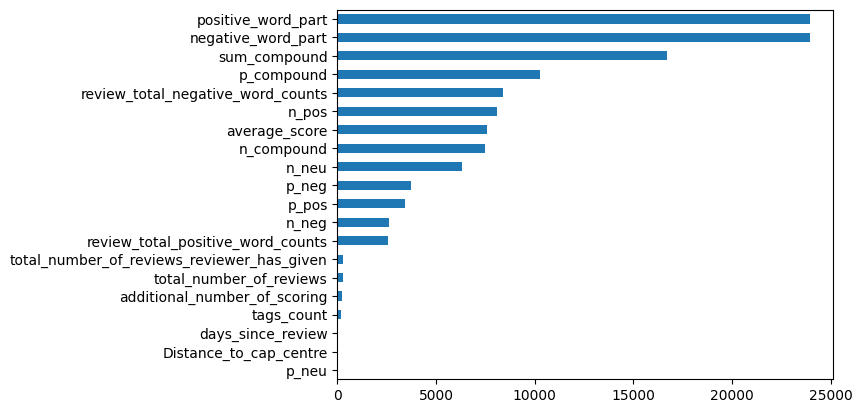

In [64]:
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn
from sklearn.feature_selection import f_classif # anova

# Метод f_classif возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. 
# Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [67]:
# дропнем непокаазтельные признаки
# Признаки города и страны дублируют друг друга потому что в каждой стране представлено только по одному городу, удалим города, а также непоказательные признаки

hotels = hotels.drop(['hotel_city_Amsterdam', 'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan', 'hotel_city_Paris', 
            'hotel_city_Vienna','p_neu', 'days_since_review', 'year'], axis = 1)

In [68]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [69]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Создание и обучение модели

In [70]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


### Оценка качества модели

In [71]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

metrics = {"MAPE":metrics.mean_absolute_percentage_error(y_test, y_pred)} # зафиксировали словарь метрик
experiment.log_metrics(metrics) # логируем метрику

MAPE: 0.14965302273182776


# Здесь еще должно быть проверочное на тестовом датасете после тренингового!!! Есть в другом файле

In [72]:
experiment.display() # подтягивает окно Comet

In [73]:
experiment.end() # завершаем логирование